# Loading elmer/ice results
Started March 4, 2025; Last updated March 14, 2025

The purpose of this notebook is to develop functions to load in elmer/ice results and process it for usage in our PINNs setup. This is used to test our synthetic momentum inversion. The elmer results are based off the steady-state gravity current simulations done by Josh Rines here: https://arxiv.org/abs/2407.20565. 

In [1]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.stats import linregress
import matplotlib.colors as colors


## Loading in csv
The elmer outputs were into a vtu, but that vtu was then saved as a csv file in ParaView. The following snippet loads in the csv

In [2]:
csv = '../elmer_results/results/vm.csv'
df = pd.read_csv(f'{csv}')
#df_cropped = df[keys]

We can take a look at what's in the pandas dataframe. 

In [3]:
df[:5]

,pressure,stress 1,stress 2,stress 3,stress 4,strainrate 1,strainrate 2,strainrate 3,strainrate 4,strainrate 5,...,height,velocity:0,velocity:1,velocity:2,mesh velocity:0,mesh velocity:1,mesh velocity:2,Points:0,Points:1,Points:2
0,5.586840,0.000673,-0.000673,0,0.000940,9.139880e-13,-4.053910e-09,0,8.769430e-13,-4.053000e-09,...,0.000000e+00,0.0,0.0,0,0,0,0,0.0,0.0,0
1,5.584310,0.000244,-0.000244,0,0.014552,2.568790e-10,-7.991770e-06,0,2.330960e-04,-7.991510e-06,...,0.000000e+00,0.0,0.0,0,0,0,0,625.0,0.0,0
2,5.565500,0.000137,-0.000137,0,0.021101,1.210860e-09,-9.477030e-06,0,7.113210e-04,-9.475820e-06,...,0.000000e+00,0.0,0.0,0,0,0,0,1250.0,0.0,0
3,5.552280,0.000109,-0.000109,0,0.023564,1.845960e-09,-9.414980e-06,0,9.906500e-04,-9.413140e-06,...,0.000000e+00,0.0,0.0,0,0,0,0,1600.0,0.0,0
4,0.214269,-0.000194,0.000194,0,0.126678,8.502470e-05,5.556210e-04,0,1.539710e-01,6.406460e-04,...,3.552710e-15,0.0,0.0,0,0,0,0,30000.0,0.0,0


Here's a snippet from some of Josh's code to load in VTU results. We can use these to interpret our pandas headers:
```
# create variables for the different fields from the .vtu file
txx = vtufile.get_point_field("stress 1") # [MPa] txx, deviatoric stress
tyy = vtufile.get_point_field("stress 2") # tyy
txy= vtufile.get_point_field("stress 4") # txy
exx = vtufile.get_point_field("strainrate 1") # exx
eyy = vtufile.get_point_field("strainrate 2") # eyy
exy = vtufile.get_point_field("strainrate 4") # exy
depth = vtufile.get_point_field("depth") # depth
height = vtufile.get_point_field("height") # height
vx = vtufile.get_point_field("velocity")[:,0] # x-velocity
vy = vtufile.get_point_field("velocity")[:,1] # y-velocity
```
Since we use z-coordinates, let's rename all the y variables to z. Now, let's select and rename these same keys

In [4]:
keys = ['stress 1', 'stress 2', 'stress 4', 'strainrate 1', 'strainrate 2', 'strainrate 4', 'Points:0', 'Points:1','depth', 'height','velocity:0', 'velocity:1', 'pressure']
new_indexes = ['txx', 'tzz', 'txz', 'exx', 'ezz', 'exz', 'x', 'z', 'd','h', 'u', 'w','p']
df_cropped = df[keys]
df_cropped.columns = new_indexes

Let's cut to near the divide so we have a bit less data to work with.

In [5]:
left_x = 0
right_x = 4000
df_filtered = df_cropped[df_cropped['x'] >= left_x] # cut to near divide
df_filtered = df_filtered[df_filtered['x']<= right_x]

Now let's calculate an effective viscosity. Note to Jonny: ignore my notes about effective viscosity I sent earlier, they don't have it defined in the convention that I actually use. The following convention is the one I'm sticking with. The general consitutive equation is:
$$\tau=2\mu\dot{\varepsilon}.$$

For ice, this is written as Glen's Flow Law:
$$\dot{\varepsilon}_{ij}=A\tau^{n-1}_e\tau_{ij},$$
where $i,j \in [x,z]$. $\tau_e$ is calculated with:
$$\tau_e^2 = \frac{1}{2}\left(\tau_{xx}^2+\tau_{zz}^2\right)+\tau_{xz}^2.$$
Solving for $\mu$ gives:
$$\mu = \frac{\tau_e^{1-n}}{2A}.$$

Since we have values of stresses and strain rates, we can calculate effective stresses and strain rates (effective strain rate follows the same formulation from its components as effective stress). Josh has a line that does this, and calculates the viscosity:
```
# create e_eff, s_eff, and viscosity variable based on stress and strain rate:
e_eff = np.sqrt(0.5*exx**2 + 0.5*eyy**2 + exy**2)
s_eff = np.sqrt(0.5*txx**2 + 0.5*tyy**2 + txy**2)
eta = 0.5*s_eff/e_eff #[MPa yr]
eta = eta*(10**6)*(31557600) #[Pa s]
eta_xx = 0.5*txx/exx #[MPa yr]
eta_xy = 0.5*txy/exy #[MPa yr]
eta_yy = 0.5*tyy/eyy #[MPa yr]
```
We do the same, and call our viscosity `mu`. We have now calculated fields of viscosity from the effective strain rates and stresses, but also from each component. Let's also add in a density variable, rho, for completion here. 

In [6]:

df_filtered['e_eff'] = np.sqrt(0.5*df_filtered['exx']**2 + 0.5*df_filtered['ezz']**2 + df_filtered['exz']**2)
df_filtered['s_eff'] = np.sqrt(0.5*df_filtered['txx']**2 + 0.5*df_filtered['tzz']**2 + df_filtered['txz']**2)
df_filtered['mu'] = 0.5*df_filtered['s_eff']/df_filtered['e_eff'] #[MPa yr]
df_filtered['mu_xx'] = 0.5*df_filtered['txx']/df_filtered['exx'] #[MPa yr]
df_filtered['mu_xz'] = 0.5*df_filtered['txz']/df_filtered['exz'] #[MPa yr]
df_filtered['mu_zz'] = 0.5*df_filtered['tzz']/df_filtered['ezz'] #[MPa yr]

df_filtered['rho'] = 910 # this was the constant density used in my elmer simulation

# to convert mu values into Pa s, *(10**6)*(31556926) #[Pa s]


Now, we can plot.

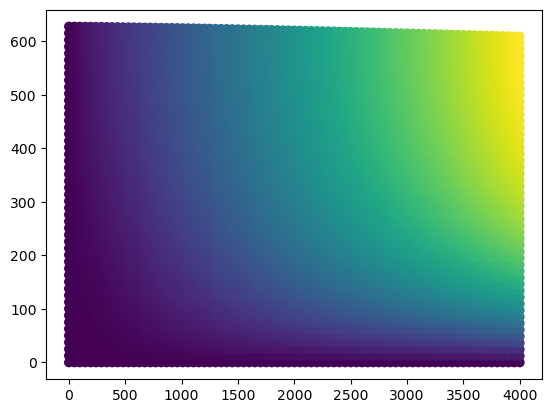

In [7]:
plt.scatter(df_filtered['x'],df_filtered['z'],c=df_filtered['u'])

Now, let's set boundary conditions. For our simplified mass conservation problem, we assume that we know the the vertical velocities throughout the ice divide. We also assume that the surface horizontal velocities, along with the shape of the surface itself, are known. We assume that at the bed, the ice density is that of glacial ice, and that the the vertical velocities are zero. We also assume that the horizontal velocities at the divide are zero.

For the momentum problem, we assume that the pressures are 0 at the surface, and that the viscosities at the left and right hand flanks are parameterizable. 

We set up our data processing function to always output these boundary conditions as options to use between models. We define them as seperate dataframes, and have them generate automatically from the provided data. We always need `df_surface` to contain the keys `u` and `p`, `df_divide` to contain `u`, `df_bed` to contain `w` and `rho`, and `df_flanks` to contain `mu`. 

In [8]:
df_surface = df_filtered[df_filtered['d']==0]
df_divide = df_filtered[df_filtered['x']==0]
df_bed = df_filtered[df_filtered['z']==0]

left_x = df_filtered['x'].min()
right_x = df_filtered['x'].max()

df_flanks = df_filtered[(df_filtered['x'] == left_x) | (df_filtered['x'] == right_x)]

Now, we use this above code to define a function that can be added to load_data_functions.py

In [9]:
def load_elmer_results(csv,left_x,right_x):
    df = pd.read_csv(f'{csv}')
    keys = ['stress 1', 'stress 2', 'stress 4', 'strainrate 1', 'strainrate 2', 'strainrate 4', 'Points:0', 'Points:1','depth', 'height','velocity:0', 'velocity:1', 'pressure']
    new_indexes = ['txx', 'tzz', 'txz', 'exx', 'ezz', 'exz', 'x', 'z', 'd','h', 'u', 'w','p']
    df_cropped = df[keys]
    df_cropped.columns = new_indexes
    df_filtered = df_cropped[df_cropped['x'] >= left_x] 
    df_filtered = df_filtered[df_filtered['x']<= right_x]

    df_filtered['e_eff'] = np.sqrt(0.5*df_filtered['exx']**2 + 0.5*df_filtered['ezz']**2 + df_filtered['exz']**2)
    df_filtered['s_eff'] = np.sqrt(0.5*df_filtered['txx']**2 + 0.5*df_filtered['tzz']**2 + df_filtered['txz']**2)
    df_filtered['mu'] = 0.5*df_filtered['s_eff']/df_filtered['e_eff'] #[MPa yr]
    df_filtered['mu_xx'] = 0.5*df_filtered['txx']/df_filtered['exx'] #[MPa yr]
    df_filtered['mu_xz'] = 0.5*df_filtered['txz']/df_filtered['exz'] #[MPa yr]
    df_filtered['mu_zz'] = 0.5*df_filtered['tzz']/df_filtered['ezz'] #[MPa yr]
    
    df_filtered['rho'] = 910 # this was the constant density used in my elmer simulation
    
    df_surface = df_filtered[df_filtered['d']==0]
    df_divide = df_filtered[df_filtered['x']==0]
    df_bed = df_filtered[df_filtered['z']==0]
    left_x = df_filtered['x'].min()
    right_x = df_filtered['x'].max()
    df_flanks = df_filtered[(df_filtered['x'] == left_x) | (df_filtered['x'] == right_x)]
    # need to add a section that calculates a mu flank estimate, and reassigns df_flanks['mu'] accordingly
    return df_filtered, df_surface, df_divide, df_bed, df_flanks

In [10]:
csv = '../elmer_results/results/pvm.csv'
df_filtered, df_surface, df_divide, df_bed, df_flanks = load_elmer_results(csv,0,4000)

The format of this output should be consistent for any function in `load_data_functions.py`. In this pandas format, there should be no nan values in the `w` column - the dropping of nans should be done in the load_data function.

The below code is to define a helper function that works on any `load_data_function` output to normalize the data. It should return a normalized version of the data. Then, a specific sampling script should be written in each model notebook to sample the specific variables needed by the model.

In [11]:
# make into a function
def normalize(df_filtered, df_surface, df_divide, df_bed, df_flanks):
    # keys that will always be there
    x = df_filtered['x'].values
    z = df_filtered['z'].values
    w = df_filtered['w'].values
    
    rho_bed = df_bed['rho'].values.mean()
    mu_flanks = df_flanks['mu'].values
    
    # assign scales - use a dict
    means_and_scales = {}
    means_and_scales['x_mean'] = jnp.mean(x)
    means_and_scales['x_range'] = (x.max() - x.min()) / 2
    means_and_scales['z_mean'] = jnp.mean(z)
    means_and_scales['z_range'] = (z.max() - z.min()) / 2
    means_and_scales['w_mean'] = jnp.mean(w)
    means_and_scales['w_range'] = jnp.std(w) * 2
    # the divide assumes that u will vary around 0
    # when we only take 1 half, this isn't true - effects? Change u_mean to see
    means_and_scales['u_mean'] = 0
    means_and_scales['u_range'] = jnp.std(w) * 2 # same as w_range
    # let's say the ice scaling is that of glacial ice (elmer uses 910)
    # let's also say the pressure scale is dependent on ice thickness
    means_and_scales['rho_range'] = rho_bed
    means_and_scales['rho_mean'] = 0
    means_and_scales['p_range'] = means_and_scales['rho_range']*9.81*means_and_scales['z_range'] # this also assumes not centered at 0 
    means_and_scales['p_mean'] = 0
    means_and_scales['mu_range'] = jnp.exp(jnp.nanmean(jnp.log(jnp.abs(mu_flanks))))
    means_and_scales['mu_mean'] = 0

    #norm_list
    df_full_norm,df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm = pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([]),pd.DataFrame([])
    
    for key in ['x','z','u','w','rho','p','mu']:
        for df,df_norm in zip([df_filtered,df_surface, df_divide, df_bed, df_flanks],[df_full_norm,df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm]):
            df_norm[key] = (df[key] - means_and_scales[f'{key}_mean'])/means_and_scales[f'{key}_range']
    
    return df_full_norm,[df_surf_norm,df_div_norm,df_bed_norm,df_flanks_norm],means_and_scales

In [12]:
df_filtered, df_surface, df_divide, df_bed, df_flanks = load_elmer_results(csv,0,4000)
df_norm,df_bc,info = normalize(df_filtered, df_surface, df_divide, df_bed, df_flanks)

In [13]:
len(df_bc)

4

In [14]:
def sample(df_norm,n_samples,df_bcs):
    # df_norm is the dataframe of interest
    # key is the rng key that we set for reproducibility 
    # n_samples is a list including number of samples, followed by number of colocation points
    def dataf(key):
        keys = random.split(key, 2) 
        X_star = df_norm[['x','z']].values
        U_star = df_norm[['u','w','rho','p','mu']].values
        n_data = X_star.shape[0]    
        print(n_data)
        idx_smp = random.choice(keys[0], jnp.arange(n_data), [n_samples[0]])
        X_smp = X_star[idx_smp,:]
        U_smp = U_star[idx_smp,:]
    
        idx_col = random.choice(keys[1], jnp.arange(n_data), [n_samples[1]])
        X_col = X_star[idx_col,:]
        U_col = U_star[idx_col,:]
        data = dict(smp=[X_smp,U_smp],col=[X_col,U_col])

        # add in bcs - currently, include all data
        for dict_key, df_bc in zip(['surf','div','bed','flanks'],df_bcs):
            X_bc = df_bc[['x','z']].values
            U_bc = df_bc[['u','w','rho','p','mu']].values
            data[dict_key] = [X_bc,U_bc]
        
        return data
    return dataf

I think this point is pretty much up to fitting with the rest of the way things work

In [97]:
X_star.shape

(4182, 2)